# CA56 - Task4: Image Segmentation Using Clustering Methods

**Course:** Data Science  
**Assignment:** CA56 (Computer Assignment 56)  
**University:** University of Tehran  
**Instructors:** Dr. Bahrak, Dr. Yaghoobzadeh, Dr. Doosti  

**Authors:** 

- Mahdy Mokhtari

- Alborz Mahmoudian

- Niloufar Mortazavi

---

**Introduction**

**The goal is to:**

- 
- 
- 
- 



## 0. Understanding Segmentation

Segmentation tasks can be categorized into multiple categories. The simplest one is **semantic segmentation**, which assigns each pixel a class label based on the object or region it belongs to, without distinguishing between different instances of the same class. For example, in a football game image, all pixels belonging to players would be labeled as "player," regardless of which specific player they represent. Instance Segmentation is another type of segmentation whose goal goes beyond semantic segmentation by not only labeling pixels by their class but also differentiating between individual instances of the same class. In the football player dataset, **instance segmentation** would assign unique labels to each player, enabling separation of player 1 from player 2, even though both belong to the "player" class. Finally **Panoptic Segmentation** combines semantic and instance segmentation, labeling every pixel with both a class and, for countable objects, an instance ID. In the context of the football dataset, panoptic segmentation would assign unique IDs to each player while labeling background elements like the ground or crowd as single, separated regions. Focus of 
this project is mainly on semantic segmentation.

## 1.Dataset Loading

Im going to move 50 images as said to anther folder which will be out data that we are gonna work with.

In [73]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import random
import shutil
import json
from skimage import color

Load from config file.

In [74]:
import json
import os

def load_config(config_file='config.json'):
    """Load the configuration settings from a JSON file."""
    if not os.path.exists(config_file):
        raise FileNotFoundError(f"Config file {config_file} not found.")
    
    with open(config_file, 'r') as file:
        config = json.load(file)
    
    return config


In [75]:
import os
import shutil
import random
import json

config = load_config('config.json')

DATASET_PATH = config.get('dataset_path', 'task4_images/my_class')
SRC_DATASET_PATH = config.get('src_dataset_path', 'images')
ANNOTATIONS_PATH = config.get('annotations_path', 'annotations/instances_default.json')

print(os.path.exists(DATASET_PATH))

# DATASET_PATH = os.path.join("task4_images", "my_class")
# SRC_DATASET_PATH = "images"
# ANNOTATIONS_PATH = os.path.join("annotations", "instances_default.json")

def copy_random_files(source_dir, destination_dir, num_files=50):
    if not os.path.isdir(destination_dir):
        try:
            os.makedirs(destination_dir, exist_ok=True)
            all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
            random_files = random.sample(all_files, num_files)

            # Copy
            for file in random_files:
                source_path = os.path.join(source_dir, file)
                destination_path = os.path.join(destination_dir, file)
                shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
                print(f"Copied: {file}")

            print(f"Successfully copied {num_files} random files from {source_dir} to {destination_dir}")

        except FileNotFoundError:
            print(f"Error: Source directory not found: {source_dir}")
        except Exception as e:
            print(f"An error occurred: {e}")


copy_random_files(SRC_DATASET_PATH, DATASET_PATH)

True


Now lets resize the images to be <u>1/16</u> their original size. This resizing makes our model **not** run into **performance** and **memory** issues.

In [76]:
class DynamicResizeTransform:
    size_factor = 16

    def __call__(self, img):
        original_width, original_height = img.size
        new_width = original_width // self.size_factor
        new_height = original_height // self.size_factor
        return transforms.Resize((new_height, new_width))(img)

#### Custom Dataset for Semantic Segmentation

Instead of using `ImageFolder`, we created a custom `SegmentationDataset` class to properly handle image–mask pairs required for semantic segmentation. This allows us to:

- Load 50 sampled images along with their corresponding segmentation annotations.
- Dynamically resize both the images and masks to reduce memory usage (1/16 of original size).
- Prepare each `(image, mask)` pair for model training or evaluation.

This setup ensures that each image is paired with a correctly formatted segmentation mask, which is essential for training semantic segmentation models.


In [77]:
import os
import json
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms

class ClusteringDataset(Dataset):
    def __init__(self, images_dir, annotations_path, transform=None):
        """
        Args:
            images_dir (str): Directory containing the images.
            annotations_path (str): Path to the annotations (COCO JSON format).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images_dir = images_dir
        self.transform = transform
        
        with open(annotations_path, 'r') as f:
            self.coco = json.load(f)

        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco['images']}
        
        self.image_files = [f for f in self.image_files if f in self.image_id_to_filename.values()]

        self.annotations_by_image_id = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            self.annotations_by_image_id.setdefault(img_id, []).append(ann)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Fetch an image and its corresponding annotations for evaluation.
        """
        image_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, image_name)

        img = Image.open(img_path).convert("RGB")

        width, height = img.size 

        if self.transform:
            img = self.transform(img)
        
        image_id = self.get_image_id_from_filename(image_name)
        annotations = self.annotations_by_image_id.get(image_id, [])
        
        mask = self.generate_mask_from_annotation(annotations, (width, height))
        
        return img, mask

    def get_image_id_from_filename(self, filename):
        """
        Given a filename, get the corresponding image_id.
        """
        for img_id, img_name in self.image_id_to_filename.items():
            if img_name == filename:
                return img_id
        return None

    def generate_mask_from_annotation(self, annotations, image_size):
        """
        Generates a binary mask from the segmentation annotations.
        """
        width, height = image_size 
        
        mask = Image.new("L", (width, height), 0)
        
        draw = ImageDraw.Draw(mask)
        
        for ann in annotations:
            if 'segmentation' in ann:
                for polygon in ann['segmentation']:
                    draw.polygon(polygon, outline=1, fill=1)
        
        return mask


In [78]:
transform = transforms.Compose([
    DynamicResizeTransform(),
    transforms.ToTensor()
])

dataset = ClusteringDataset(DATASET_PATH, ANNOTATIONS_PATH, transform=transform)

Visualizing a sample

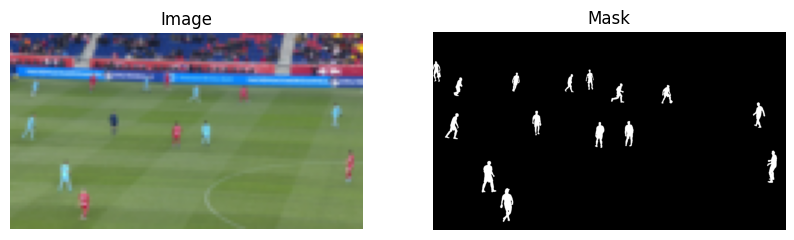

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample():
    img, mask = dataset[0]  

    img = img.permute(1, 2, 0).numpy() 
    mask = np.array(mask.convert("L"))  
    mask = mask.squeeze() 

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off') 

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off') 

    plt.show()

visualize_sample()


In [80]:
print("Number of datas in the dataset class:", len(dataset))

Number of datas in the dataset class: 50


## 2.Creating Features

In [81]:
def tensor_to_numpy_img(img_tensor):
    """
    img_tensor: torch.Tensor of shape (C, H, W), floats in [0,1]
    returns: NumPy array of shape (H, W, 3), uint8 in [0,255]
    """
    np_img = img_tensor.permute(1, 2, 0).cpu().numpy()     # C×H×W → H×W×C
    np_img = (np_img * 255).round().astype(np.uint8)
    return np_img

In [82]:
def extract_rgb_features(image: np.ndarray) -> np.ndarray:
    """
    image: H×W×3 uint8 RGB
    returns: (H*W)×3 float32 array of [R, G, B] per pixel
    """
    h, w, c = image.shape
    assert c == 3, "Expected 3 channels (RGB)"
    
    rgb_feats = image.reshape(-1, 3).astype(np.float32)
    rgb_feats /= 255.0  
    
    return rgb_feats

In [83]:
def extract_lab_features(image: np.ndarray) -> np.ndarray:
    """
    image: H×W×3 uint8 RGB
    returns: (H*W)×3 float32 array of [L, a, b] per pixel
    """
    lab = color.rgb2lab(image / 255.0)  
    return lab.reshape(-1, 3).astype(np.float32)

In [84]:
def extract_rgb_xy_features(image: np.ndarray, normalize: bool = True, spatial_weight: float = 0.05) -> np.ndarray:
    """
    image: H×W×3 uint8 RGB
    normalize: if True, x and y in [0,1], else raw pixel indices
    spatial_weight: A factor to scale down the influence of spatial coordinates in the feature vector
    returns: (H*W)×5 float32 array of [R, G, B, x, y] per pixel
    """
    h, w, _ = image.shape
    rgb_feats = extract_rgb_features(image) 
    ys, xs = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    xs = xs.reshape(-1).astype(np.float32)
    ys = ys.reshape(-1).astype(np.float32)
    
    if normalize:
        xs /= (w - 1) 
        ys /= (h - 1)
        
    coords = np.stack([xs, ys], axis=1) * spatial_weight  
    
    return np.hstack([rgb_feats, coords])


In [85]:
def extract_lab_xy_features(image: np.ndarray, normalize: bool = True, spatial_weight: float = 0.05) -> np.ndarray:
    """
    image: H×W×3 uint8 RGB
    normalize: if True, x and y in [0,1], else raw pixel indices
    spatial_weight: A factor to scale down the influence of spatial coordinates in the feature vector
    returns: (H*W)×5 float32 array of [L, a, b, x, y] per pixel
    """
    lab_feats = extract_lab_features(image) 
    h, w, _ = image.shape
    ys, xs = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    xs = xs.reshape(-1).astype(np.float32)
    ys = ys.reshape(-1).astype(np.float32)
    
    if normalize:
        xs /= (w - 1)
        ys /= (h - 1)
    
    coords = np.stack([xs, ys], axis=1) * spatial_weight
    
    return np.hstack([lab_feats, coords])


In [86]:
from skimage.feature import local_binary_pattern
from skimage.filters import sobel
import numpy as np

def extract_combined_features(image: np.ndarray, normalize: bool = True, rgb_weight: float = 10.0) -> np.ndarray:
    """
    Extracts combined features from the image, including RGB, gradients, and spatial coordinates.
    
    Args:
        image: H×W×3 uint8 RGB image (Numpy array).
        normalize: If True, normalize the (x, y) coordinates to the range [0, 1] and RGB features.
        rgb_weight: A factor to increase the importance of RGB features.
        
    Returns:
        A (H*W)×7 float32 array of features, including [R, G, B, Sobel_X, Sobel_Y, x, y].
    """
    rgb_feats = extract_rgb_features(image)
    
    if normalize:
        rgb_feats /= 255.0
    
    rgb_feats *= rgb_weight 

    sobel_x = sobel(image[:, :, 0])
    sobel_y = sobel(image[:, :, 1]) 
    sobel_gradients = np.stack([sobel_x, sobel_y], axis=-1) 
    
    h, w, _ = image.shape
    ys, xs = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    xs = xs.reshape(-1).astype(np.float32)
    ys = ys.reshape(-1).astype(np.float32)
    
    if normalize:
        xs /= (w - 1)
        ys /= (h - 1)
    
    spatial_feats = np.stack([xs, ys], axis=1) / 10  # Divide by 10 to reduce their impact (experiment with different factors)
    
    combined_feats = np.hstack([rgb_feats, sobel_gradients.reshape(-1, 2), spatial_feats])
    
    return combined_feats


In [87]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

def extract_resnet50_features(image: np.ndarray, normalize: bool = True) -> np.ndarray:
    """
    Extracts features from a pretrained ResNet50 model for an image.
    
    Args:
        image: H×W×3 uint8 RGB image (Numpy array).
        normalize: If True, normalize the (x, y) coordinates to the range [0, 1].
        
    Returns:
        A (H*W)×2048 float32 array of features from ResNet50's penultimate layer (2048 channels).
    """
    # Load pretrained ResNet50 model
    model = models.resnet50(pretrained=True)
    model.eval()  # Set model to evaluation mode
    
    # Define the image transformation pipeline (resize, normalize, convert to tensor)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor (H×W×3 uint8 -> C×H×W float32)
        transforms.Resize((224, 224)),  # Resize image to 224x224, as required by ResNet50
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Convert the image to a tensor
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)
    
    # Pass the image through the network to get features
    with torch.no_grad():
        features = model.conv1(image_tensor)
        features = model.bn1(features)
        features = model.relu(features)
        features = model.maxpool(features)
        
        # Pass through the first few layers
        features = model.layer1(features)
        features = model.layer2(features)
        features = model.layer3(features)
        features = model.layer4(features)
        
        # Get the penultimate layer (before the final classifier)
        features = model.avgpool(features)
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 2048)
    
    # Convert features to numpy array (H×W×2048)
    features_np = features.numpy()

    # Since the feature size is 2048 per image (from the ResNet50 penultimate layer),
    # you can reshape or use these features for clustering.
    
    # Normalize and flatten the feature array if needed (reshape it as you would with RGB)
    if normalize:
        features_np = features_np / np.linalg.norm(features_np, axis=1, keepdims=True)
    
    return features_np



In [88]:
import numpy as np
from skimage import color, filters
from skimage.filters import sobel

img_tensor, mask_tensor = dataset[0] 
img_np = tensor_to_numpy_img(img_tensor) 

print(img_tensor.size())

feats_rgb    = extract_rgb_features(img_np)
feats_lab    = extract_lab_features(img_np)
feats_rgb_xy = extract_rgb_xy_features(img_np)
feats_lab_xy = extract_lab_xy_features(img_np)
feats_combined = extract_combined_features(img_np)
# feats_pretrainedResnet50 = extract_resnet50_features(img_np)

h, w, _ = img_np.shape

print("Shapes:", feats_rgb.shape, feats_lab.shape, feats_rgb_xy.shape, feats_lab_xy.shape)

torch.Size([3, 67, 120])
Shapes: (8040, 3) (8040, 3) (8040, 5) (8040, 5)


## 3.Cluster Pixels

In [89]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

### K-means

In [90]:
feats_list = [feats_rgb, feats_lab, feats_rgb_xy, feats_lab_xy, feats_combined]
feature_set_names = ["RGB", "Lab", "RGB + XY", "Lab + XY", "Combined"]  # Descriptive names for each feature set
feats = feats_rgb_xy

k_range = range(2, 7)
num_features = len(feats_list)

In [91]:
# Function to tune K using silhouette score
def tune_k_for_kmeans(feats: np.ndarray, k_range: range) -> int:
    """
    Tune K for K-Means using silhouette score.
    
    Args:
        feats: Feature matrix (H * W, n_features)
        k_range: Range of K values to test (e.g., range(2, 7))
    
    Returns:
        Best K according to silhouette score.
    """
    sil_scores = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42).fit(feats)
        lbls = km.labels_
        sil = silhouette_score(feats, lbls)
        sil_scores[k] = sil

    best_k = max(sil_scores, key=sil_scores.get)
    print(f"Best k according to silhouette score: {best_k}")
    return best_k

In [92]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

def elbow_method(feats: np.ndarray, k_range: range = range(1, 11)) -> int:
    """
    Determines the optimal number of clusters using the Elbow Method.
    
    Args:
        feats: Feature matrix (H * W, n_features)
        k_range: Range of K values to test (default is range(1, 11))
    
    Returns:
        The optimal K determined by the elbow method.
    """
    inertia_values = []
    
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42).fit(feats)
        inertia_values.append(km.inertia_)
    
    plt.figure()
    plt.plot(k_range, inertia_values, 'bo-')
    plt.xlabel('Number of clusters K')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.title('Elbow Method for Optimal K')
    plt.show()
    
    inertia_diff = np.diff(inertia_values)
    inertia_diff2 = np.diff(inertia_diff)
    
    elbow_k = np.argmin(inertia_diff2) + 2  # Adding 2 to account for the shift in indices
    
    print(f"Optimal k based on the elbow method: {elbow_k}")
    
    return elbow_k


In [93]:
# Function to fit KMeans with the best K
def fit_kmeans(feats: np.ndarray, best_k: int) -> np.ndarray:
    """
    Fit KMeans with the best K.
    
    Args:
        feats: Feature matrix (H * W, n_features)
        best_k: The best k from silhouette score
        
    Returns:
        KMeans labels reshaped to the image's dimensions.
    """
    kmeans_sil = KMeans(n_clusters=best_k, random_state=42).fit(feats)
    labels_km_sil = kmeans_sil.labels_
    return labels_km_sil

In [94]:
def visualize_segmentation(img_np: np.ndarray, seg_km_sil: np.ndarray, best_k: int, feature_set_name: str, h: int, w: int):
    """
    Visualize the original image and the segmentation result side by side.
    
    Args:
        img_np: Original image as numpy array
        seg_km_sil: Segmented labels from KMeans
        best_k: The best k for KMeans
        feature_set_name: The name of the feature set for the title
        h: Image height
        w: Image width
    """
    seg_km_sil = seg_km_sil.reshape(h, w)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    ax[0].imshow(img_np)
    ax[0].set_title(f"Original Image\n")
    ax[0].axis("off")

    ax[1].imshow(seg_km_sil, cmap="tab20")
    ax[1].set_title(f"K-Means (k={best_k})\n{feature_set_name}")
    ax[1].axis("off")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()



Best k according to silhouette score: 5


<Figure size 1500x2500 with 0 Axes>

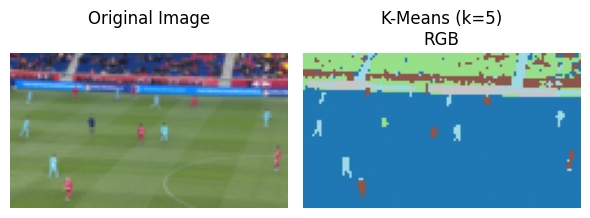

Best k according to silhouette score: 2


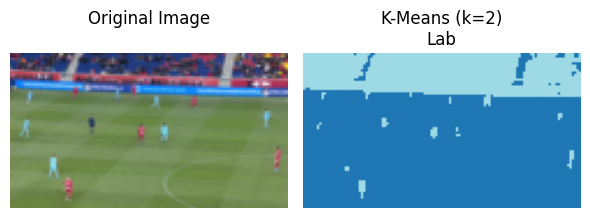

Best k according to silhouette score: 4


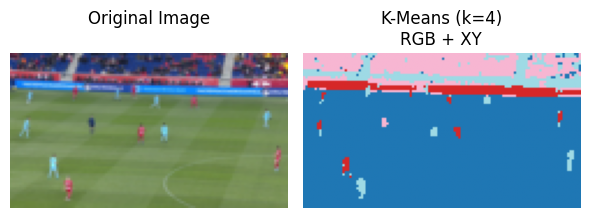

Best k according to silhouette score: 2


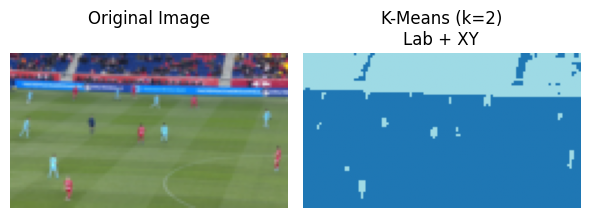

Best k according to silhouette score: 2


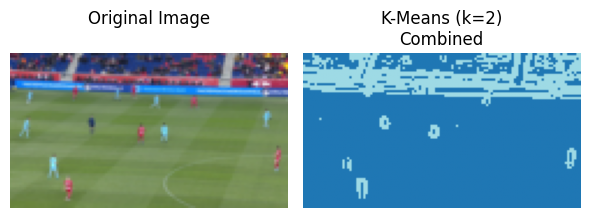

In [95]:
plt.figure(figsize=(15, 5 * num_features)) 

for idx, feature_set in enumerate(feats_list):
    feats = feature_set 

    best_k = tune_k_for_kmeans(feats, k_range)

    labels_km_sil = fit_kmeans(feats, best_k)

    feature_set_name = feature_set_names[idx] 
    seg_km_sil = labels_km_sil.reshape(h, w)  

    visualize_segmentation(img_np, labels_km_sil, best_k, feature_set_name, h, w)


### K-Means Clustering with Elbow Method

In this section, we apply the Elbow Method to determine the optimal number of clusters (K) for each feature set. The elbow point is identified by evaluating the inertia (within-cluster sum of squares) across a range of K values.

For each feature set:
- The Elbow Method is used to estimate the best K.
- K-Means clustering is applied with the selected K.
- The resulting cluster labels are reshaped into segmentation masks.
- The segmented results are visualized to assess the quality of pixel clustering.

This approach helps us identify the most appropriate number of clusters that balances model complexity and segmentation performance.


<Figure size 1500x2500 with 0 Axes>

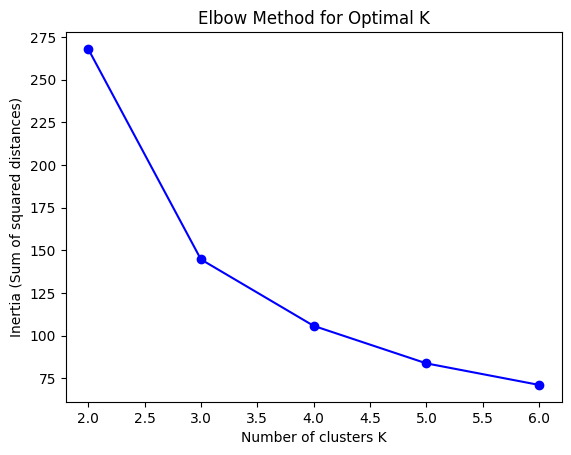

Optimal k based on the elbow method: 4


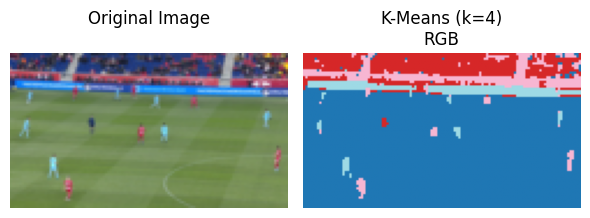

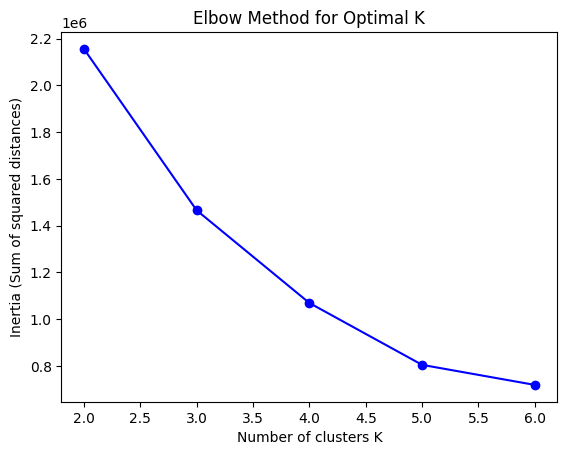

Optimal k based on the elbow method: 3


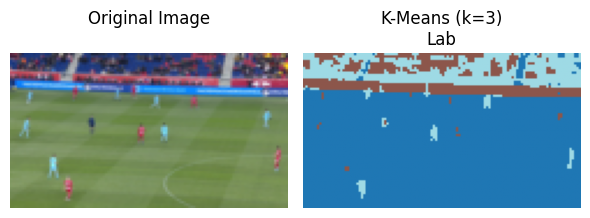

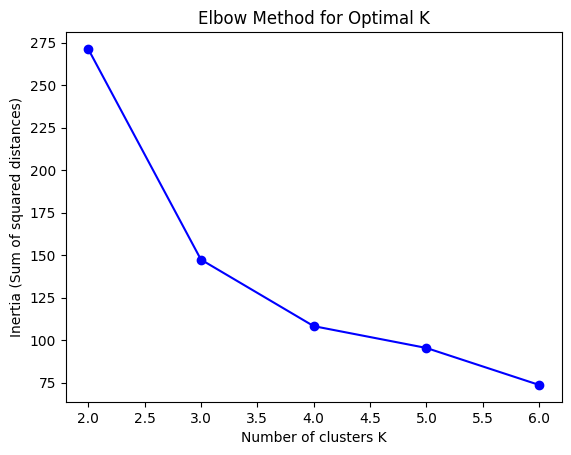

Optimal k based on the elbow method: 4


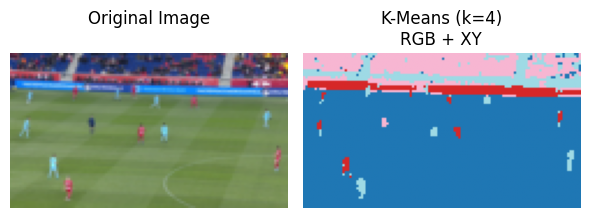

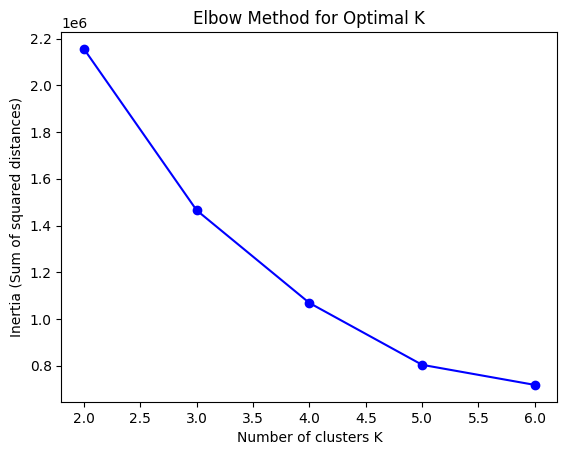

Optimal k based on the elbow method: 3


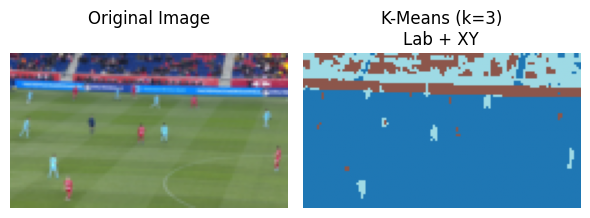

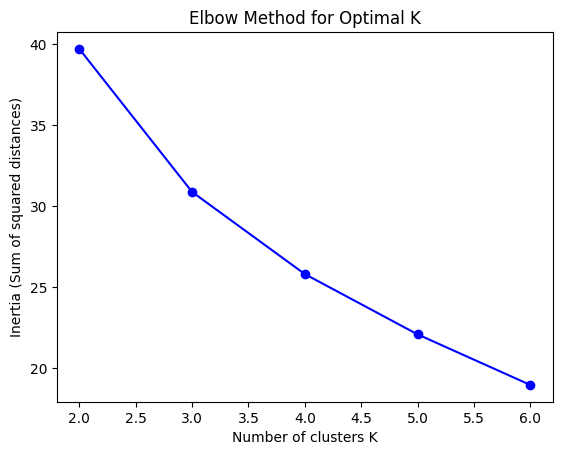

Optimal k based on the elbow method: 4


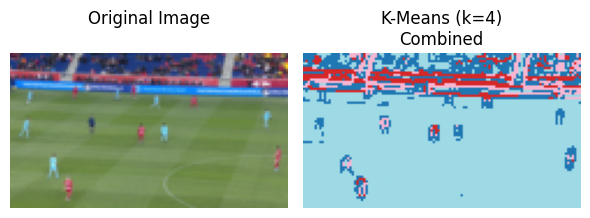

In [96]:
plt.figure(figsize=(15, 5 * num_features))  

for idx, feature_set in enumerate(feats_list):
    feats = feature_set 

    elbowed_k = elbow_method(feats, k_range)

    labels_km_sil = fit_kmeans(feats, elbowed_k)

    feature_set_name = feature_set_names[idx]  
    seg_km_sil = labels_km_sil.reshape(h, w)

    visualize_segmentation(img_np, labels_km_sil, elbowed_k, feature_set_name, h, w)


### DB-Scan

### DBSCAN Parameter Selection with Elbow Method

In this section, we use the **k-distance plot** and the **elbow method** to determine the optimal **epsilon (eps)** parameter for DBSCAN. The plot helps identify the point where the distance between points increases significantly, indicating the best `eps` value. This method is used to visually detect the "elbow" of the curve, which helps in selecting the appropriate distance threshold for clustering.


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [98]:
def k_distance_plot(feats: np.ndarray, k: int = 20):
    """
    Generate the k-distance plot to help choose the best epsilon (eps) for DBSCAN.
    
    Args:
        feats: Feature matrix (H * W, n_features).
        k: Number of neighbors to consider for k-distance plot (min_samples or higher).
        
    Returns:
        Sorted distances and the optimal eps determined by the "elbow" in the plot.
    """
    nbrs = NearestNeighbors(n_neighbors=k).fit(feats)
    distances, indices = nbrs.kneighbors(feats)
    
    distances = np.sort(distances[:, k-1], axis=0)

    return distances

In [99]:
def determine_eps_from_plot_with_input(distances: np.ndarray) -> float:
    """
    Ask the user to manually input the "elbow" point based on the k-distance plot.
    
    Args:
        distances: The sorted distances from the k-distance plot.
        
    Returns:
        Optimal epsilon (eps) for DBSCAN.
    """
    plt.figure(figsize=(10, 5))  # Adjusting plot size
    plt.plot(distances, marker='o', color='b', linestyle='-', markersize=5)  # Adding markers for each point
    plt.title("k-distance Plot", fontsize=14)
    plt.xlabel("Points sorted by distance", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)  # Adding grid lines for better visualization
    
    x_ticks_step = len(distances) // 15
    plt.xticks(np.arange(0, len(distances), x_ticks_step), rotation=45)
    
    y_ticks_step = (max(distances) - min(distances)) / 15  # Adjust step size for around 15 y-ticks
    plt.yticks(np.arange(min(distances), max(distances), y_ticks_step))
    
    plt.show()

    elbow_idx = int(input(f"Enter the index of the elbow point (0-based index, recommend looking at the plot): "))

    eps = distances[elbow_idx]

    print(f"Optimal epsilon (eps) chosen by user: {eps}")
    return eps


In [100]:
# Function to fit DBSCAN with determined eps and min_samples
def fit_dbscan(feats: np.ndarray, eps: float, min_samples: int = 20) -> np.ndarray:
    """
    Fit DBSCAN with the given epsilon (eps) and min_samples.
    
    Args:
        feats: Feature matrix (H * W, n_features).
        eps: The epsilon (eps) value for DBSCAN.
        min_samples: The minimum samples for DBSCAN.
        
    Returns:
        Labels from DBSCAN clustering.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels_db = db.fit_predict(feats)
    return labels_db

In [101]:
def visualize_dbscan_results(img_np: np.ndarray, labels_db: np.ndarray, h: int, w: int, eps: float, min_samples: int, feats_title: str):
    """
    Visualize the original image and DBSCAN segmentation side by side with fixed size for all plots.
    
    Args:
        img_np: Original image as numpy array.
        labels_db: DBSCAN labels (clusters).
        h: Image height.
        w: Image width.
        eps: epsilon used for DBSCAN.
        min_samples: minimum samples for DBSCAN.
        feats_title: A string describing the feature set used for DBSCAN.
    """
    labels_reshaped = labels_db.reshape(h, w)
    
    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.gca().set_aspect('equal', adjustable='box')  

    plt.subplot(1, 2, 2)
    plt.imshow(labels_reshaped, cmap="tab20")
    plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})\n{feats_title}")
    plt.axis("off")
    plt.gca().set_aspect('equal', adjustable='box')  
    plt.tight_layout()
    plt.show()


In [102]:
MIN_SAMPLES_DBSCAN = 20
EPS_DBSCAN = 0.1  # we dont use this becuase its gets calculated by the elbow method

<Figure size 1500x2500 with 0 Axes>

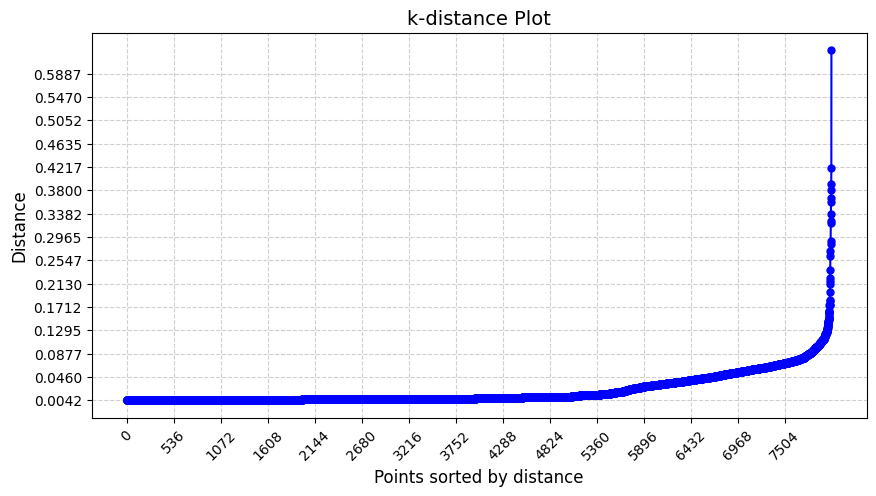

Optimal epsilon (eps) chosen by user: 0.07011473902338027
Epsilon found: 0.07011473902338027


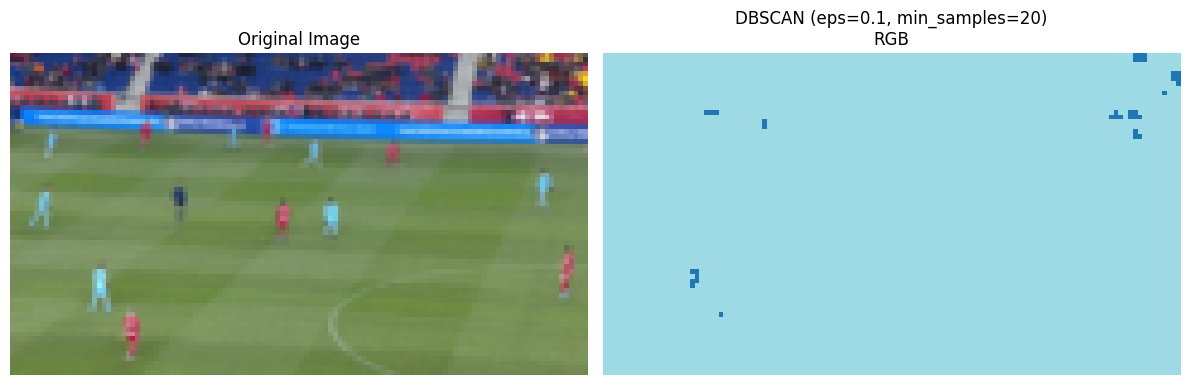

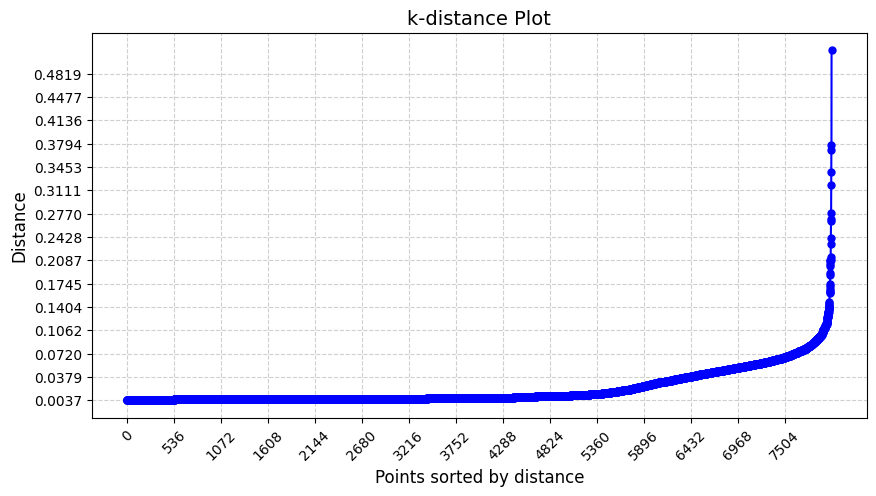

Optimal epsilon (eps) chosen by user: 0.0712686298376847
Epsilon found: 0.0712686298376847


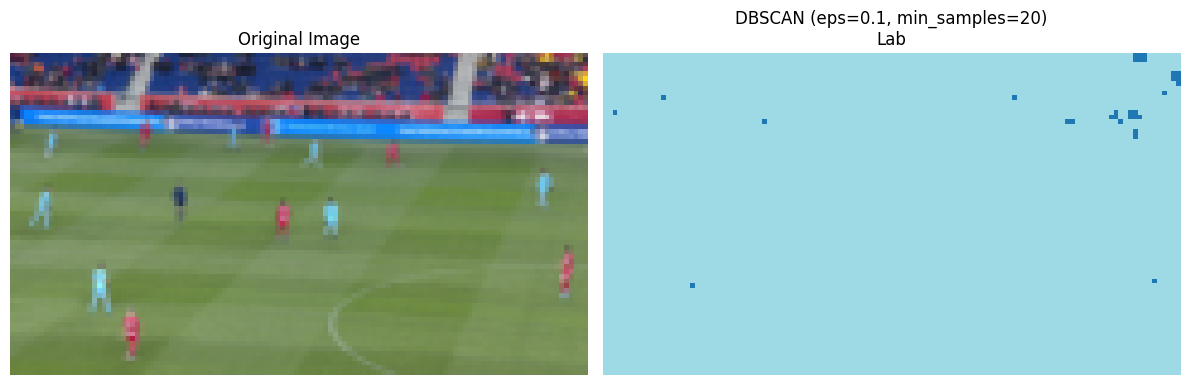

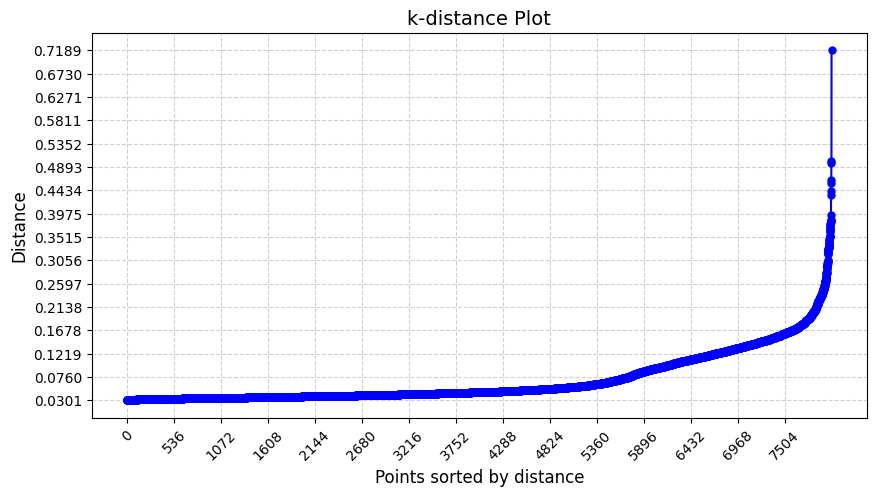

Optimal epsilon (eps) chosen by user: 0.16801926584152405
Epsilon found: 0.16801926584152405


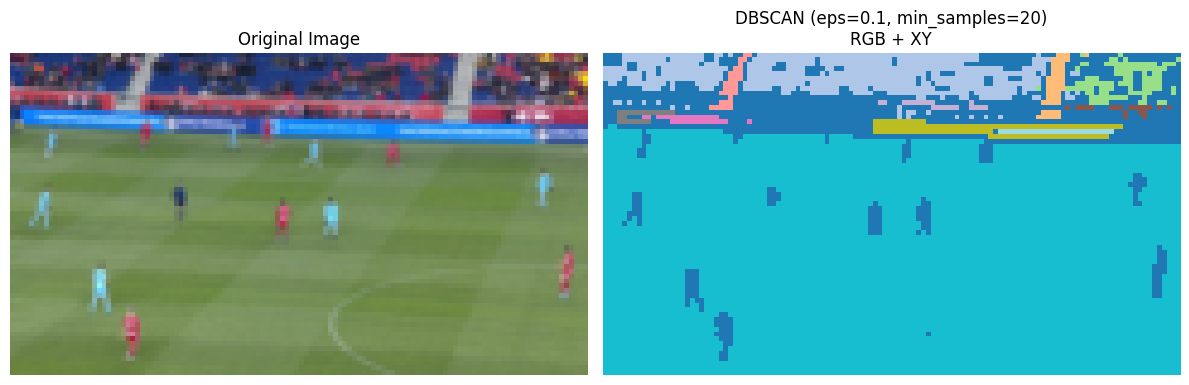

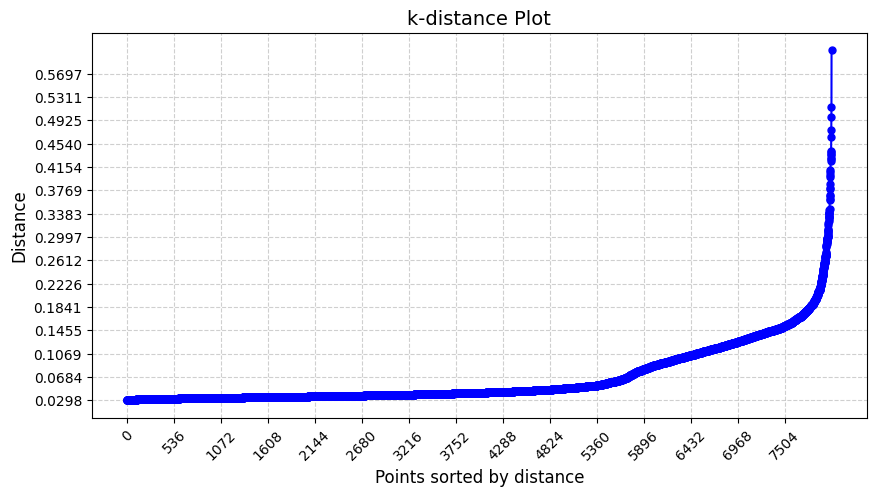

Optimal epsilon (eps) chosen by user: 0.15980285845683656
Epsilon found: 0.15980285845683656


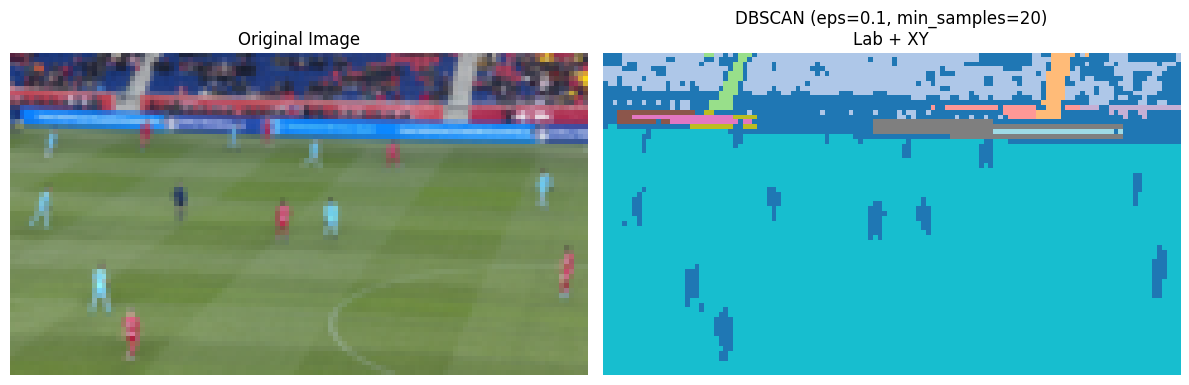

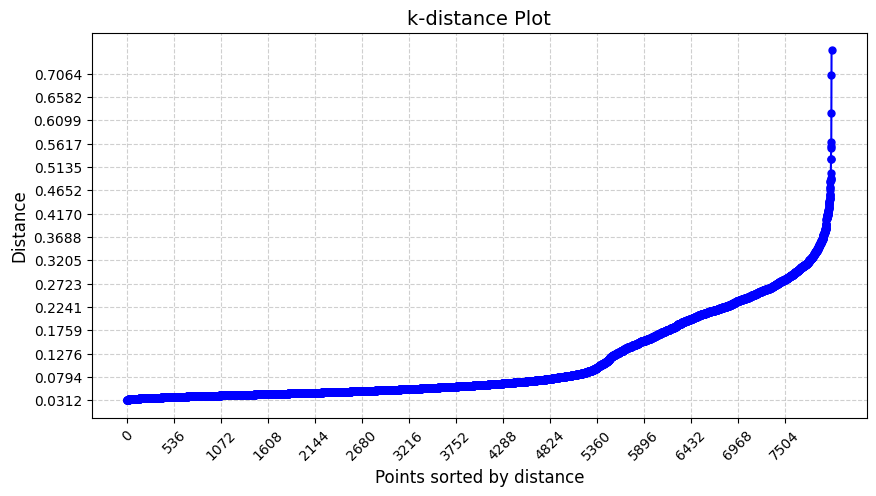

Optimal epsilon (eps) chosen by user: 0.29073390951850453
Epsilon found: 0.29073390951850453


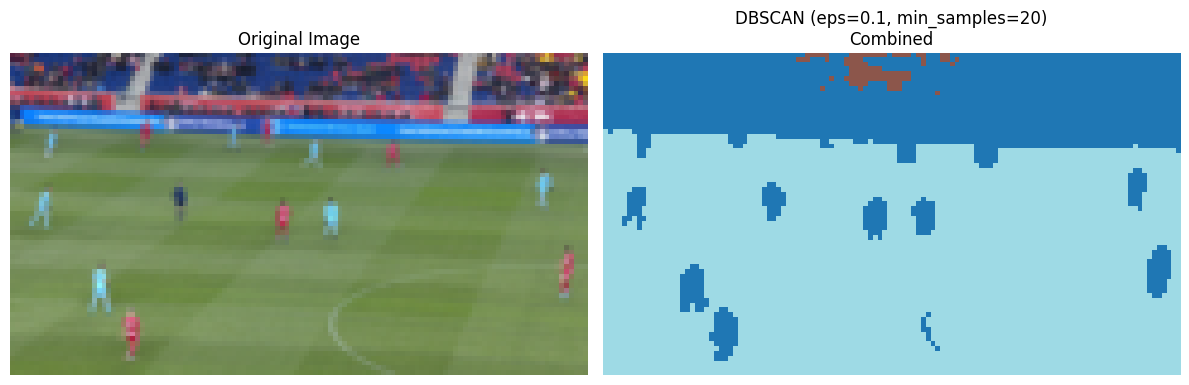

In [103]:
plt.figure(figsize=(15, 5 * num_features)) 

for idx, feats in enumerate(feats_list):

    scaler = MinMaxScaler()
    feats_scaled = scaler.fit_transform(feats)

    distances = k_distance_plot(feats_scaled)

    eps = determine_eps_from_plot_with_input(distances)

    print("Epsilon found:", eps)

    labels_db = fit_dbscan(feats_scaled, EPS_DBSCAN, min_samples=MIN_SAMPLES_DBSCAN)

    visualize_dbscan_results(img_np, labels_db, h, w, EPS_DBSCAN, MIN_SAMPLES_DBSCAN, feature_set_names[idx])

### DBSCAN Parameter Tuning with Randomized Search

In this section, we use **Randomized Search** to optimize the **DBSCAN** parameters: `eps` (epsilon) and `min_samples`. The goal is to find the best combination of these parameters to achieve optimal clustering results. The `eps` parameter controls the maximum distance between two samples for them to be considered as in the same neighborhood, while `min_samples` determines the minimum number of points required to form a dense region. The results are visualized with the segmented clusters for each feature set.


In [104]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler
from sklearn.utils import parallel_backend
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

In [105]:
def simple_random_search_dbscan(feats: np.ndarray, param_dist: dict, n_iter: int = 30, random_state: int = 42):
    """
    A simplified random search for tuning DBSCAN using silhouette score.
    
    Args:
        feats: Feature matrix (H * W, n_features).
        param_dist: Dict with keys 'eps' and 'min_samples' and their value ranges (lists).
        n_iter: Number of random combinations to try.
        random_state: Seed for reproducibility.
        
    Returns:
        Tuple of best parameters and best silhouette score.
    """
    best_score = -1
    best_params = None
    
    # Generate random combinations of hyperparameters
    param_combinations = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    
    for params in param_combinations:
        model = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        labels = model.fit_predict(feats)

        # Skip if all noise or only one cluster
        if len(set(labels)) <= 1 or -1 in set(labels):
            continue
        
        score = silhouette_score(feats, labels)
        if score > best_score:
            best_score = score
            best_params = params
    
    print(f"Best parameters: {best_params}, Silhouette Score: {best_score:.4f}")
    return best_params, best_score


In [106]:
# Function to tune DBSCAN hyperparameters (eps and min_samples) using RandomizedSearchCV
def tune_dbscan_params(feats: np.ndarray, param_dist: dict, n_iter: int = 100):
    """
    Tune DBSCAN parameters (eps and min_samples) using RandomizedSearchCV.
    
    Args:
        feats: Feature matrix (H * W, n_features).
        param_dist: Dictionary of parameter distributions for `eps` and `min_samples`.
        n_iter: Number of iterations for RandomizedSearchCV.
        
    Returns:
        Best parameters for DBSCAN.
    """
    db = DBSCAN()  # DBSCAN model
    
    # RandomizedSearchCV with silhouette score as the scoring method
    random_search = RandomizedSearchCV(db, param_distributions=param_dist, n_iter=n_iter, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    random_search.fit(feats)  # Fit to the feature matrix
    
    print(f"Best parameters from Random Search: {random_search.best_params_}")
    return random_search.best_params_

In [107]:
def visualize_dbscan_results(img_np: np.ndarray, labels_db: np.ndarray, h: int, w: int, eps: float, min_samples: int, feats_title: str):
    """
    Visualize the original image and DBSCAN segmentation side by side with fixed size for all plots.
    
    Args:
        img_np: Original image as numpy array.
        labels_db: DBSCAN labels (clusters).
        h: Image height.
        w: Image width.
        eps: epsilon used for DBSCAN.
        min_samples: minimum samples for DBSCAN.
        feats_title: A string describing the feature set used for DBSCAN.
    """
    labels_reshaped = labels_db.reshape(h, w)
    
    plt.figure(figsize=(12, 6))  

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.gca().set_aspect('equal', adjustable='box')  

    plt.subplot(1, 2, 2)
    plt.imshow(labels_reshaped, cmap="tab20")
    plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})\n{feats_title}")
    plt.axis("off")
    plt.gca().set_aspect('equal', adjustable='box')  

    plt.tight_layout()  
    plt.show()

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters from Random Search: {'min_samples': np.int64(14), 'eps': np.float64(0.49)}


<Figure size 1500x2500 with 0 Axes>

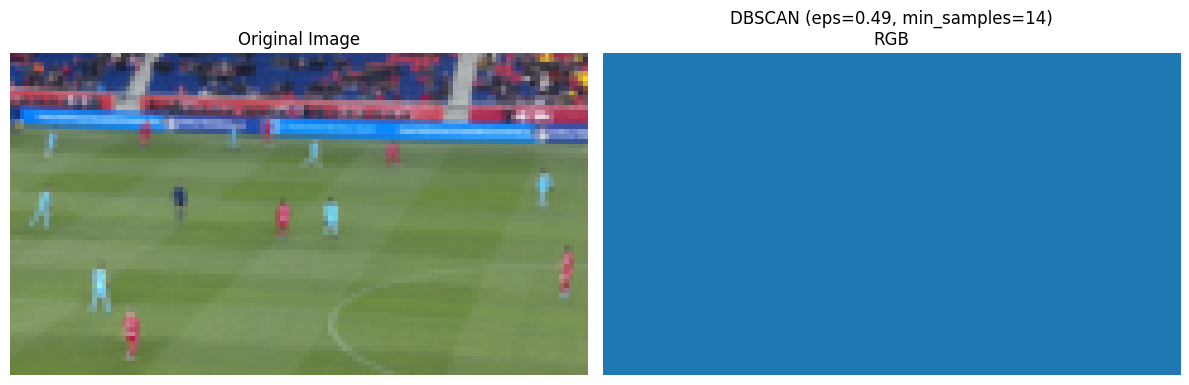

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters from Random Search: {'min_samples': np.int64(33), 'eps': np.float64(0.16)}


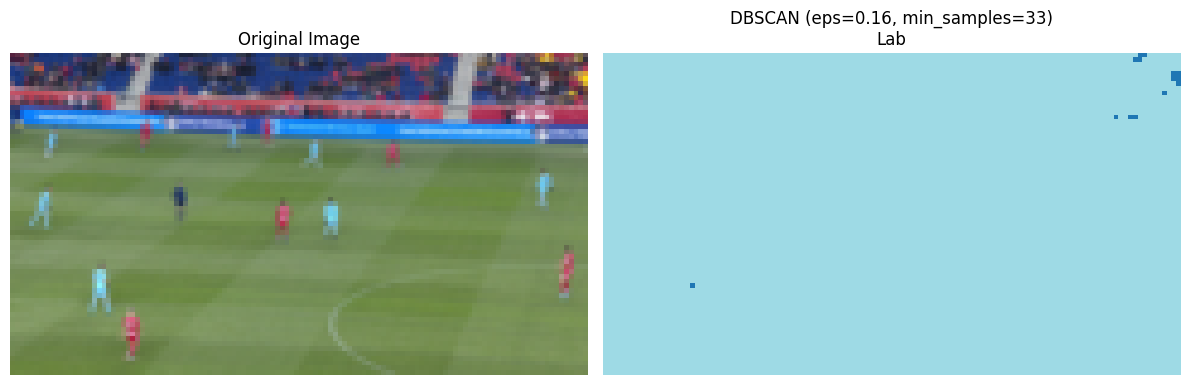

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters from Random Search: {'min_samples': np.int64(36), 'eps': np.float64(0.11)}


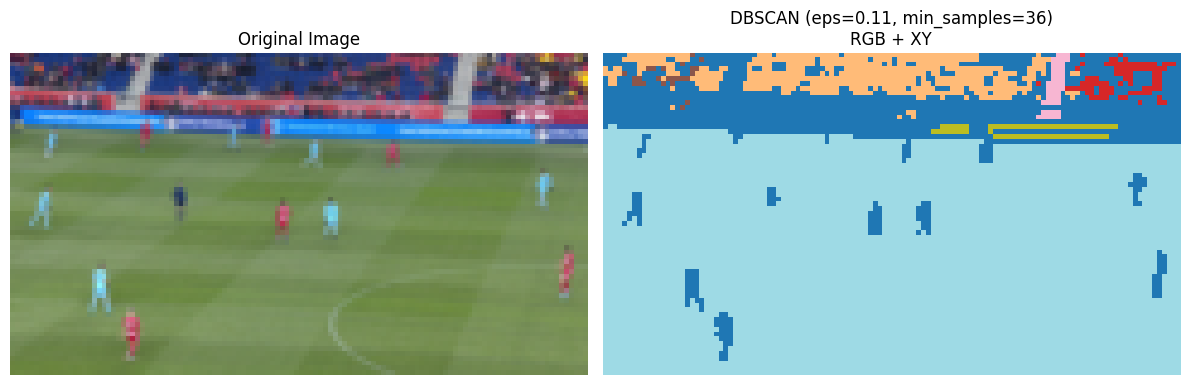

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters from Random Search: {'min_samples': np.int64(33), 'eps': np.float64(0.23)}


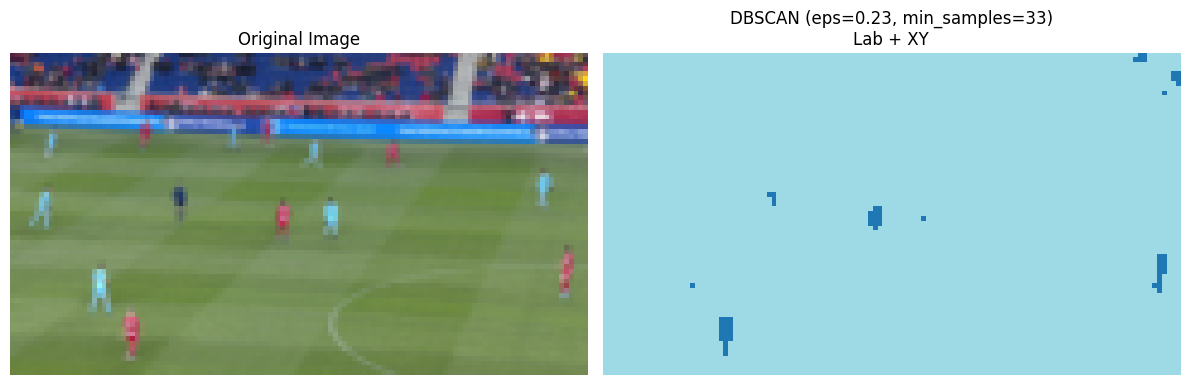

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters from Random Search: {'min_samples': np.int64(7), 'eps': np.float64(0.13)}


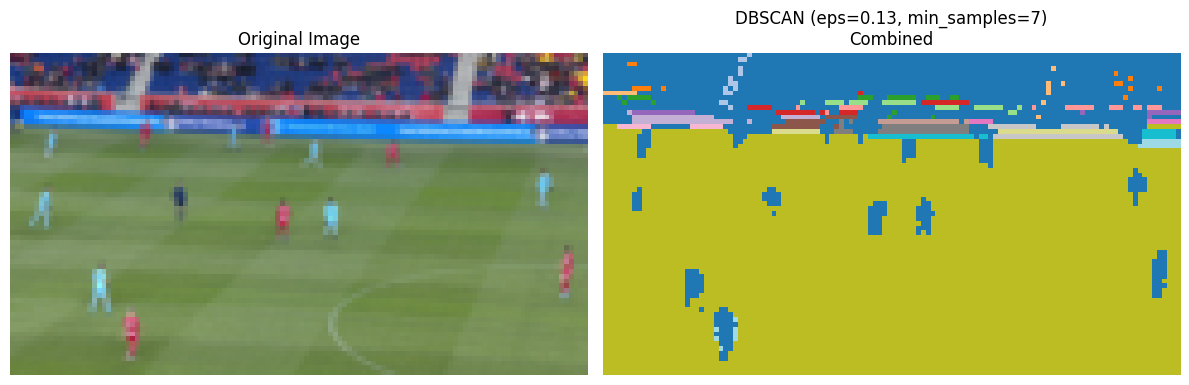

In [108]:
param_dist = {
    'eps': np.linspace(0.01, 0.5, 50),
    'min_samples': np.arange(5, 50, 1)
}

plt.figure(figsize=(15, 5 * num_features)) 

for idx, feats in enumerate(feats_list):
    scaler = MinMaxScaler()
    feats_scaled = scaler.fit_transform(feats)

    best_params = tune_dbscan_params(feats_scaled, param_dist)

    labels_db = fit_dbscan_with_best_params(feats_scaled, best_params['eps'], best_params['min_samples'])

    visualize_dbscan_results(img_np, labels_db, h, w, best_params['eps'], best_params['min_samples'], feature_set_names[idx])


### Hierarchical Clustering

We applied **hierarchical (agglomerative) clustering** to segment images using different pixel-level feature sets such as RGB and RGB+XY.  
The optimal number of clusters was determined using the **silhouette score**, which evaluates clustering quality across a range of cluster counts.

Each pixel was assigned a label based on its cluster, and the labels were reshaped to form segmentation masks.  
This unsupervised method enabled us to segment meaningful regions in the image without relying on ground-truth annotations.


In [109]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [110]:
def find_optimal_clusters_hierarchical(feats, k_range, linkage='ward', affinity='euclidean'):
    """
    Uses silhouette score to find the best number of clusters for hierarchical clustering.

    Args:
        feats (np.ndarray): Feature array (flattened H*W, F)
        k_range (list): Range of k values to evaluate (e.g. range(2, 10))
        linkage (str): 'ward', 'complete', 'average', or 'single'
        affinity (str): Distance metric (ignored if linkage='ward')

    Returns:
        int: Optimal number of clusters based on silhouette score
    """
    best_score = -1
    best_k = k_range[0]

    for k in k_range:
        try:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=affinity)
            labels = model.fit_predict(feats)
            if len(set(labels)) > 1:
                score = silhouette_score(feats, labels)
                if score > best_score:
                    best_score = score
                    best_k = k
        except Exception:
            continue

    print(f"[Hierarchical] Best silhouette score: {best_score:.4f} at k = {best_k}")
    return best_k


In [111]:
def fit_hierarchical(feats, n_clusters, linkage='ward', affinity='euclidean'):
    """
    Fit AgglomerativeClustering and return labels.

    Args:
        feats (np.ndarray): Feature matrix (H*W, F)
        n_clusters (int): Optimal number of clusters
        linkage (str): Linkage strategy
        affinity (str): Distance metric

    Returns:
        np.ndarray: Cluster labels (H*W,)
    """
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)

    labels = model.fit_predict(feats)
    return labels

In [112]:
def visualize_hierarchical_segmentation(img_np, seg_map, feature_set_name, k, idx, total, cmap='tab20'):
    """
    Visualize original image and hierarchical segmentation result side-by-side.

    Args:
        img_np (np.ndarray): Original RGB image (H, W, 3)
        seg_map (np.ndarray): Segmentation map (H, W)
        feature_set_name (str): Name of the feature set
        k (int): Number of clusters used
        idx (int): Index of current row in subplot grid (starting from 0)
        total (int): Total number of feature sets to display
        cmap (str): Colormap for segmentation visualization
    """
    # Two columns per row: original image | segmentation
    plt.subplot(total, 2, 2 * idx + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"{feature_set_name} - Original Image")

    plt.subplot(total, 2, 2 * idx + 2)
    plt.imshow(seg_map, cmap=cmap)
    plt.axis('off')
    plt.title(f"{feature_set_name} - Clustering (k={k})")

    plt.show()

[Hierarchical] Best silhouette score: 0.6388 at k = 6


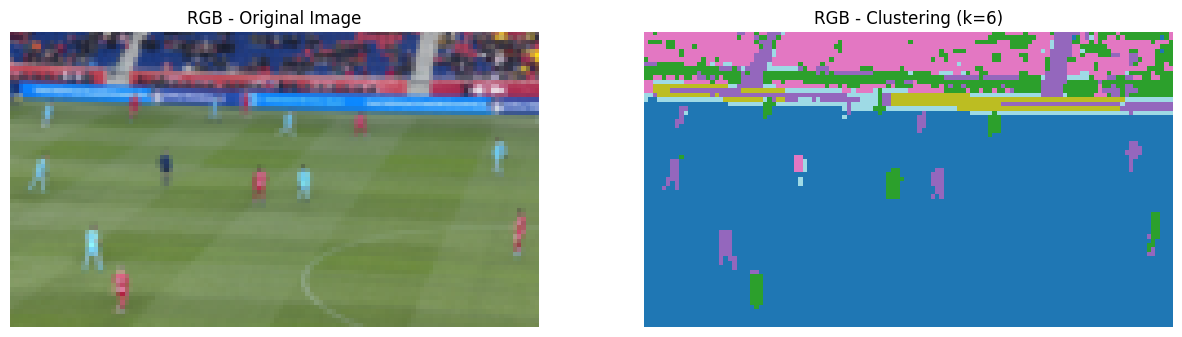

[Hierarchical] Best silhouette score: 0.7328 at k = 2


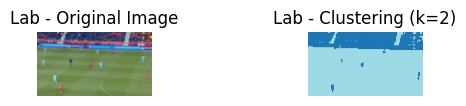

[Hierarchical] Best silhouette score: 0.6477 at k = 5


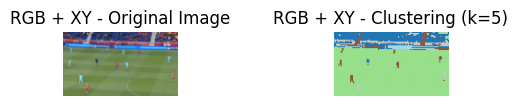

[Hierarchical] Best silhouette score: 0.7331 at k = 2


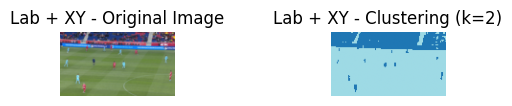

[Hierarchical] Best silhouette score: 0.6421 at k = 2


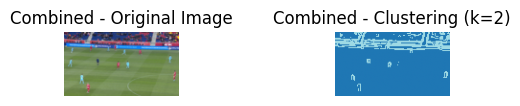

In [113]:
linkage = 'ward'       # Options: 'ward', 'complete', 'average', 'single'
affinity = 'euclidean' # Required if linkage != 'ward'; ignored for 'ward'

plt.figure(figsize=(15, 5 * len(feats_list)))

for idx, feats in enumerate(feats_list):
    feature_set_name = feature_set_names[idx]

    best_k = find_optimal_clusters_hierarchical(
        feats, k_range, linkage=linkage, affinity=affinity
    )

    labels = fit_hierarchical(feats, best_k, linkage=linkage, affinity=affinity)
    seg_map = labels.reshape(h, w)

    visualize_hierarchical_segmentation(img_np, seg_map, feature_set_name, best_k, idx, len(feats_list))


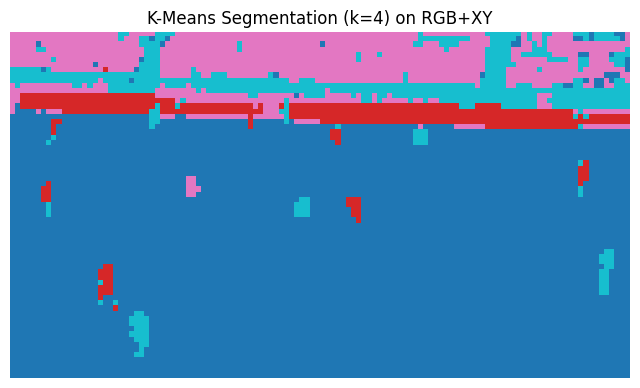

In [114]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume feats_rgb_qy has shape (H*W, F)
k = 4
h, w = img_np.shape[:2]  # if not already defined

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(feats_rgb_xy)

# Reshape flat labels to segmentation map
seg_map_k4 = labels.reshape(h, w)

# Visualize
plt.figure(figsize=(8, 5))
plt.imshow(seg_map_k4, cmap='tab10')
plt.axis('off')
plt.title("K-Means Segmentation (k=4) on RGB+XY")
plt.show()


##  4. Filtering & Merging

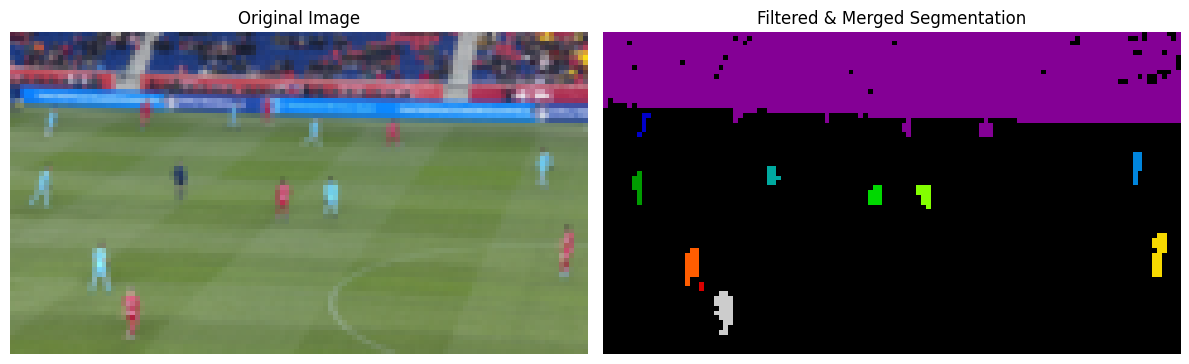

In [115]:
from collections import Counter
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter labels based on cluster size
label_counts = Counter(labels)  # labels = flat array from clustering

min_pixels = 50
max_pixels = 5000

valid_labels = [label for label, count in label_counts.items()
                if min_pixels < count < max_pixels]

# Step 2: Create binary mask
filtered_mask = np.isin(labels, valid_labels).astype(np.uint8)
filtered_mask_2d = filtered_mask.reshape(h, w)

# Step 3: Merge connected components
merged_mask = label(filtered_mask_2d, connectivity=2)

# Step 4: Visualization: show original image and mask side by side
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image")

# Merged segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(merged_mask, cmap='nipy_spectral')
plt.axis('off')
plt.title("Filtered & Merged Segmentation")

plt.tight_layout()
plt.show()


## 5. Even more clustering

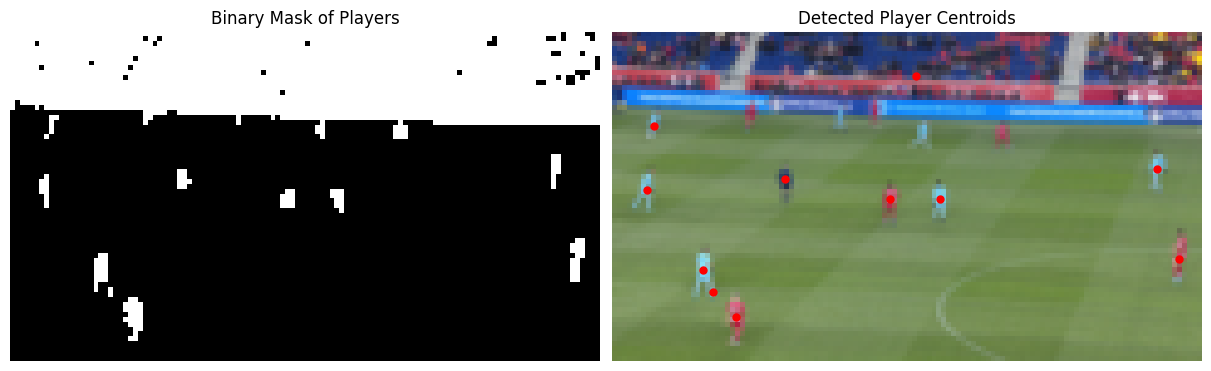

In [120]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import numpy as np

# 1. Create binary mask (1 for player regions, 0 for background)
binary_mask = (merged_mask > 0).astype(np.uint8)

# 2. Label connected components
labeled_cc = label(binary_mask)

# 3. Compute region properties (we only need centroids here)
props = regionprops(labeled_cc)

# 4. Extract centroids
centroids = [prop.centroid for prop in props]  # (row, col) format

# 5. Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# 5a. Show binary mask
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title("Binary Mask of Players")
axes[0].axis('off')

# 5b. Overlay centroids on original image
axes[1].imshow(img_np)
axes[1].set_title("Detected Player Centroids")
axes[1].axis('off')

# Plot each centroid
for (r, c) in centroids:
    axes[1].plot(c, r, 'ro', markersize=5)

plt.show()


## 6. Even more advanced features

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\NoteBook/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [26:10<00:00, 29.8kB/s]
C:\Users\NoteBook\AppData\Local\Temp\ipykernel_23796\2187662270.py:72: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  clean = closing(clean, square(3))


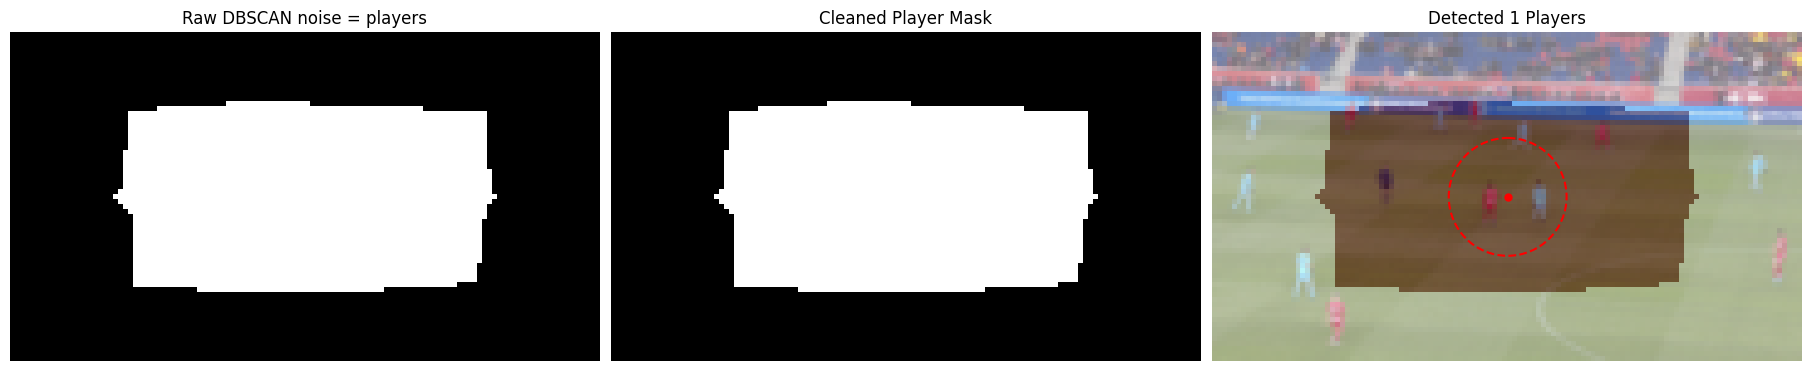

In [121]:
# —————————————————————————————————————————————
# Part 6 continuation: More Advanced Features!
# (assumes `img_np = tensor_to_numpy_img(img_tensor)` has already been called)
# —————————————————————————————————————————————

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

import numpy as np
from sklearn.cluster import DBSCAN

from skimage.measure     import label, regionprops
from skimage.morphology  import closing, square
import matplotlib.pyplot as plt
from matplotlib.patches  import Circle

# 0) DEVICE SETUP
# ---------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) SET UP PRETRAINED BACKBONE
# -----------------------------
resnet   = models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet.children())[:-2])  # drop avgpool+fc
backbone = backbone.to(device).eval()

transform = T.Compose([
    T.ToTensor(),  # img_np is uint8 H×W×3 → Tensor[3×H×W] in [0,1]
    T.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225])
])

# 2) EXTRACT DENSE FEATURES
# --------------------------
# img_np: H×W×3 uint8
img_t = transform(img_np).unsqueeze(0).to(device)  # → 1×3×H×W
with torch.no_grad():
    feats = backbone(img_t)                        # → 1×C×h×w

# 3) UPSAMPLE TO ORIGINAL RESOLUTION
# ----------------------------------
_, C, h, w = feats.shape
feats_up = F.interpolate(
    feats,
    size=img_np.shape[:2],    # H×W
    mode='bilinear',
    align_corners=False
)
feats_up = feats_up.squeeze(0).permute(1,2,0).cpu().numpy()  # H×W×C on CPU

# 4) DBSCAN CLUSTERING IN FEATURE SPACE
# -------------------------------------
H, W, _ = feats_up.shape
X = feats_up.reshape(-1, C)                         # (H·W)×C

db = DBSCAN(eps=2.5, min_samples=50, n_jobs=-1).fit(X)
labels = db.labels_.reshape(H, W)                   # -1=noise, 0,1,2...=clusters

# Build raw player mask: noise → candidate players
player_mask6 = (labels == -1).astype(np.uint8)

# 5) CLEANUP & CONNECTED COMPONENTS
# ---------------------------------
lc    = label(player_mask6)
clean = np.zeros_like(player_mask6)
for region in regionprops(lc):
    if region.area > 200:                           # drop small noise
        clean[lc == region.label] = 1
clean = closing(clean, square(3))

labeled_cc = label(clean)
props      = regionprops(labeled_cc)
centroids  = [prop.centroid for prop in props]     # list of (row, col)

# 6) VISUALIZE RESULTS
# --------------------
fig, axes = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)

axes[0].imshow(player_mask6, cmap='gray', vmin=0, vmax=1)
axes[0].set_title("Raw DBSCAN noise = players")
axes[0].axis('off')

axes[1].imshow(clean, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Cleaned Player Mask")
axes[1].axis('off')

axes[2].imshow(img_np)
axes[2].imshow(clean, cmap='Reds', alpha=0.4)
for (r, c) in centroids:
    circ = Circle((c, r), radius=12,
                  edgecolor='r', facecolor='none',
                  linestyle='--', linewidth=1.5)
    axes[2].add_patch(circ)
    axes[2].plot(c, r, 'ro', markersize=5)
axes[2].set_title(f"Detected {len(centroids)} Players")
axes[2].axis('off')

plt.show()
